**Aims**:
 - Explore best ways to present the data
 - Prepare the publication-quality figure for the manuscript

In [1]:
%run notebook_setup.ipynb

In [2]:
%vault from pubmed_derived_data import literature

Imported `literature` (904B0F94) at Wednesday, 05. Aug 2020 16:24

In [3]:
duplicated_doi = literature.doi.dropna()[literature.doi.dropna().duplicated()]
with_duplicated_doi = literature[literature.doi.isin(duplicated_doi)]
with_duplicated_doi

,multi-omics,pan-omics,trans-omics,poly-omics,cross-omics,multi-table omics,multi-source omics,multi-view omics,multi-modal omics,multi-block omics,...,has_doi,year,term,has_url_in_abstract,PMC,has_pmc,has_full_text,full_text,article_type,abstract_clean
uid,,,,,,,,,,,,,,,,,,,,,
31312515,True,False,False,False,False,False,False,False,False,False,...,True,2019.0,multi-omics,False,PMC6616462,True,True,\n \n\n \nIntroduction\nToday’s system...,brief-report,Computational tools for multiomics data integr...
32636387,True,False,False,False,False,False,False,False,False,False,...,True,2019.0,multi-omics,False,NaN,False,NaN,NaN,NaN,Computational tools for multiomics data integr...


In [4]:
# all duplicates are identical:
assert all(with_duplicated_doi.groupby('doi').agg(set).apply(len) == 1)

Remove all but the first occurrence of duplicates:

In [5]:
uids_of_all_but_first = with_duplicated_doi.reset_index().groupby('doi').agg(list).uid.apply(lambda x: x[1:]).sum()
uids_of_all_but_first

[32636387]

In [6]:
literature = literature[~literature.index.isin(uids_of_all_but_first)].copy()

In [7]:
from pandas import Series, to_datetime

In [8]:
from search_terms import primary_terms, secondary_terms, descriptive_terms
terms = [*primary_terms, *secondary_terms, *descriptive_terms]

In [9]:
literature = literature.replace({float('nan'): None}).infer_objects()
literature.date = to_datetime(literature.date)
%R -i literature -i terms

In [10]:
%%R
library(ComplexUpset)
source('helpers/plots.R')
source('helpers/colors.R')

# Publication figures

In [11]:
%vault from pubmed_derived_data import predicted_article_types, reliable_article_types

Imported:

 - `predicted_article_types` (3D39430E)
 - `reliable_article_types` (5D584CB5)

at Wednesday, 05. Aug 2020 16:24

In [12]:
%vault from pubmed_derived_data import code_repositories

Imported `code_repositories` (5FF4AA2D) at Wednesday, 05. Aug 2020 16:24

In [13]:
from pandas import concat

In [14]:
combined_article_types = concat([
    predicted_article_types,
    reliable_article_types
]).loc[literature.index]

In [15]:
%vault from pubmed_derived_data import omics_features

Imported `omics_features` (32CBB0C4) at Wednesday, 05. Aug 2020 16:24

In [16]:
from helpers.text_processing import prefix_remover

In [17]:
omics_columns = omics_features.columns

omes_or_omics = (
    omics_features[omics_columns[omics_columns.str.startswith('ome_or_omic_')]]
    .rename(columns=prefix_remover('ome_or_omic_'))
)

In [18]:
literature['omic_terms_detected'] = omes_or_omics.sum(axis=1)

In [19]:
%vault from pubmed_derived_data import domain_features

Imported `domain_features` (9CBD2CED) at Wednesday, 05. Aug 2020 16:24

In [20]:
data = (
    literature
    .drop(columns=['full_text', 'abstract'])
    .join(combined_article_types)
    .join(code_repositories)
    .join(omics_features)
    .join(
        domain_features
        [domain_features.columns[domain_features.columns.str.startswith('mentiones_')]]
    )
)
data['is_type_predicted'] = data.index.isin(predicted_article_types.index)

In [21]:
type_names = {
    'is_review': 'Review',
    'is_method': 'Computational method',
    'is_other_research_article': 'Other research article',
    'is_other': 'Other'
}

In [22]:
def get_type(t):
    if len(t) > 1:
        return 'multiple'
    if len(t):
        return type_names[list(t)[0]]
    return 'unknown'

In [23]:
data['chosen_type'] = combined_article_types.apply(lambda x: get_type(set(x[x != False].index)), axis=1)
data['chosen_type'].value_counts()

Other research article    2335
Review                     505
multiple                   205
Other                      145
unknown                    139
Computational method       126
Name: chosen_type, dtype: int64

In [24]:
from pandas import DataFrame

In [25]:
from statistics import mean
from helpers.stats import bootstrap

In [26]:
oo = []

for predicted in [True, False]:
    for type in combined_article_types.columns:
        d = data[(data[type] != False) & (data['is_type_predicted'] == predicted)].dropna(subset=['omic_terms_detected'])
        boot = bootstrap(list(d['omic_terms_detected']), stat=mean)
        oo.append({
            'is_type_predicted': predicted,
            'type': type_names[type],
            'mean_omics_detected': d['omic_terms_detected'].mean(),
            'mean_omics_detected_ci_lower': boot['lower'],
            'mean_omics_detected_ci_upper': boot['upper']
        })

oo = DataFrame(oo)

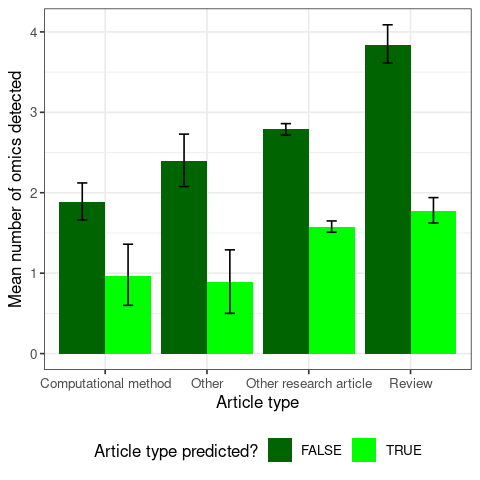

In [27]:
%%R -i oo -r 110
(
    ggplot(oo, aes(x=type, y=mean_omics_detected, fill=is_type_predicted))
    + geom_col(position='dodge')
    + geom_errorbar(
        aes(ymin=mean_omics_detected_ci_lower, ymax=mean_omics_detected_ci_upper),
        width=.2,
        position=position_dodge(width = 0.9)
    )
    + theme_bw()
    + scale_fill_manual(values=c('FALSE'='darkgreen', 'TRUE'='green'), name='Article type predicted?')
    + xlab('Article type')
    + ylab('Mean number of omics detected')
    + theme(legend.position = 'bottom')
)

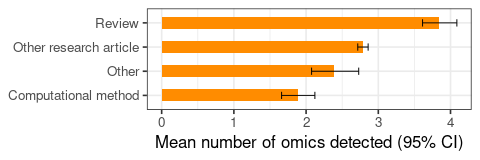

In [28]:
%%R -i oo -r 110 -h 160

plot_counts_summary =function(...) {(
    ggplot(oo[oo$is_type_predicted == FALSE, ], aes(x=type, y=mean_omics_detected))
    + geom_col(
        position='dodge', fill='darkorange',
        ...
    )
    + geom_errorbar(
        aes(ymin=mean_omics_detected_ci_lower, ymax=mean_omics_detected_ci_upper),
        width=.3,
        position=position_dodge(width=0.9),
        size=0.3
    )
    + theme_bw()
    + ylab('Mean number of omics detected (95% CI)')
    + theme(legend.position='bottom', axis.title.y=element_blank())
    + coord_flip()
)}
plot_counts_summary(width=0.5)

In [29]:
integ = 'integrated omics*'
multix = 'multi-view omics**'
other = 'other terms***'
data['term_group'] = data.term.replace({    
    'integrated omics': integ,
    'integrative omics': integ,
    'integromics': integ,
    'multi-block omics': multix,
    'multi-modal omics': multix,
    'multi-source omics': multix,
    'multi-view omics': multix,
    'cross-omics': other,
    'pan-omics': other,
    'poly-omics': other,
    'trans-omics': other,
    'multiple': 'multiple terms'
})

In [30]:
%R -i data

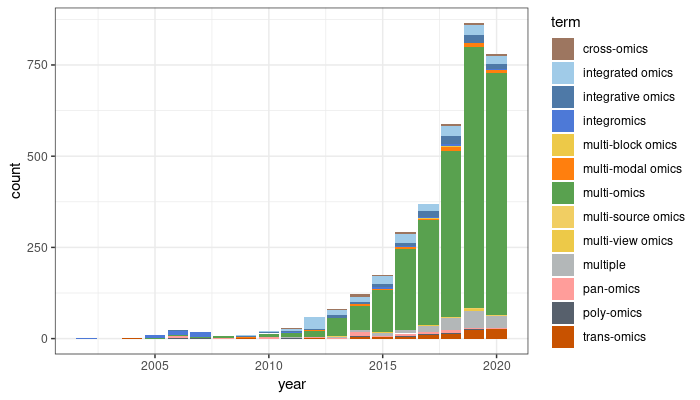

In [31]:
%%R -w 700 -h 400 -r 100
(
    ggplot(data, aes(x=year, fill=term))
    + geom_bar()
    + scale_fill_manual(values=terms_colors)
    + theme_bw()
)

In [32]:
literature[literature[list(terms)].sum(axis=1) > 2][['title', 'doi', 'abstract_clean']]

,title,doi,abstract_clean
uid,,,
28624903,Early Diagnosis of Sepsis: Is an Integrated Om...,10.1007/s40291-017-0282-z,Sepsis remains one of the leading causes of de...
30006342,"Integrated Omics: Tools, Advances, and Future ...",10.1530/JME-18-0055,With the rapid adoption of high-throughput omi...
32186712,Adaptive multi-source multi-view latent featur...,10.1093/bib/bbaa028,Accumulating evidence has shown that microRNAs...
32675233,A mechanism-aware and multiomic machine-learni...,10.1073/pnas.2002959117,Metabolic modeling and machine learning are ke...


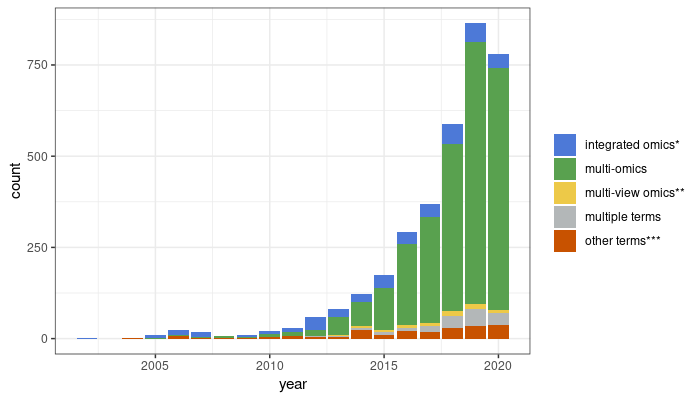

In [33]:
%%R -w 700 -h 400 -r 100 -i integ -i multix
terms_group_colors = c(
    terms_colors,
    c(
        'multi-omics'='#59A14F',
        'multi-view omics**'='#EDC948',
        'integrated omics*'='#4D79D7',
        'multiple terms'='#b3b7b8',
        'other terms***'='#c85200'
    )
)

term_counts = (
    ggplot(data, aes(x=year, fill=term_group))
    + geom_bar()
    + scale_fill_manual(values=terms_group_colors, name='')
    + theme(legend.position = 'bottom')
    + theme_bw()
)
term_counts

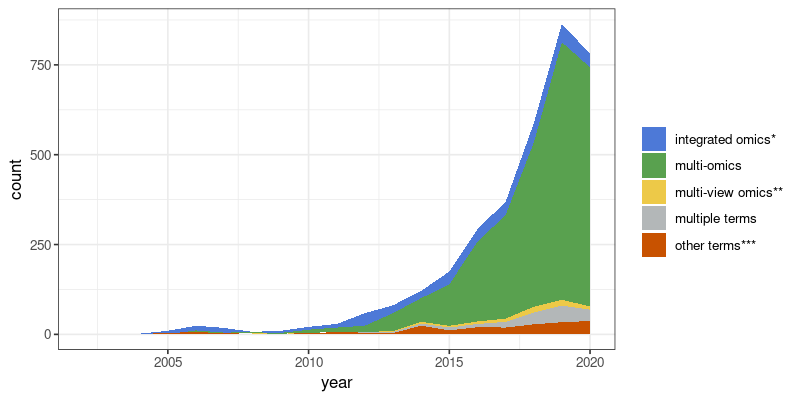

In [34]:
%%R -w 800 -h 400 -r 110

term_counts = (
    ggplot(data, aes(x=year, fill=term_group))
    + geom_area(stat='count')
    + scale_fill_manual(values=terms_group_colors, name='')
    + theme(legend.position = 'bottom')
    + theme_bw()
)
term_counts

In [35]:
%vault from pubmed_derived_data import all_articles_by_journal_and_year

Imported `all_articles_by_journal_and_year` (AB6E261E) at Wednesday, 05. Aug 2020 16:24

In [36]:
total_articles_in_popular_multi_omics_journals = all_articles_by_journal_and_year.groupby('year')['count'].sum()
total_articles_in_popular_multi_omics_journals.head(2)

year
2002    60303
2004    69921
Name: count, dtype: int64

In [37]:
term_groups_summary = data.assign(one=1).groupby(['year', 'term_group']).one.sum().rename('count').reset_index()
total_by_year = term_groups_summary.groupby('year')['count'].sum()

present = list(term_groups_summary[['term_group', 'year']].apply(tuple, axis=1))
for term in set(term_groups_summary.term_group):
    for year in set(term_groups_summary.year):
        if (term, year) not in present:
            term_groups_summary = term_groups_summary.append({
                'term_group': term,
                'year': year,
                'count': 0
            }, ignore_index=True)
term_groups_summary['count_adjusted'] = term_groups_summary['count'] / term_groups_summary.year.map(total_articles_in_popular_multi_omics_journals)
total_by_year.head(8)

year
2002.0     1
2004.0     2
2005.0    10
2006.0    24
2007.0    18
2008.0     7
2009.0    10
2010.0    21
Name: count, dtype: int64

In [38]:
start_with_year = total_by_year[total_by_year <= 3].idxmax() + 1
term_groups_summary = term_groups_summary[term_groups_summary.year >= start_with_year].copy()
start_with_year

2005.0

In [39]:
term_groups_summary['yearly_fraction'] = term_groups_summary['count'] / term_groups_summary.year.map(term_groups_summary.groupby('year')['count'].sum())

In [40]:
from datetime import date
SEARCH_DATE = date(year=2020, month=7, day=25)

In [41]:
term_groups_summary['complete_year'] = (term_groups_summary.year + 1).replace({2021: SEARCH_DATE.year + SEARCH_DATE.timetuple().tm_yday / 365})

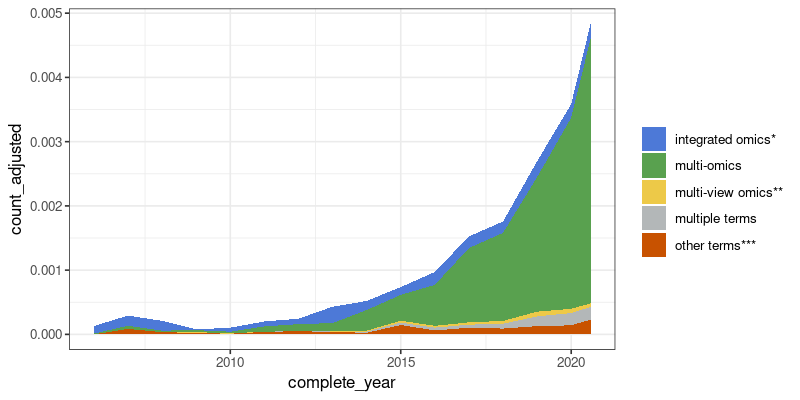

In [42]:
%%R -w 800 -h 400 -r 110 -i term_groups_summary

(
    ggplot(term_groups_summary, aes(x=complete_year, fill=term_group, y=count_adjusted))
    + geom_area(stat='identity')
    + scale_fill_manual(values=terms_group_colors, name='')
    + theme(legend.position = 'bottom')
    + theme_bw()
)

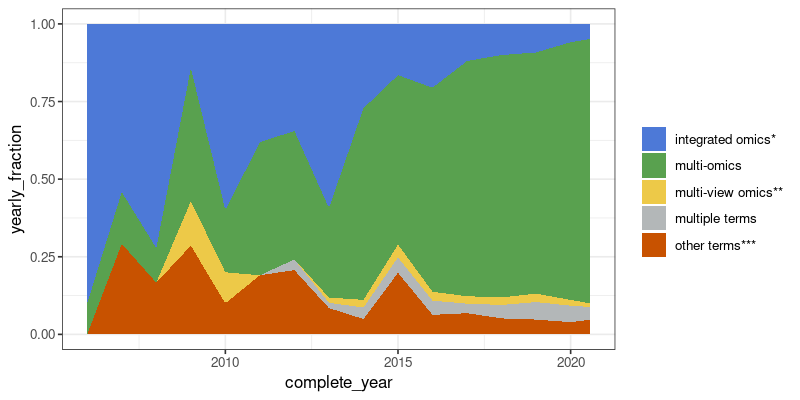

In [43]:
%%R -w 800 -h 400 -r 110 -i term_groups_summary

term_popularity = (
    ggplot(term_groups_summary, aes(x=complete_year, fill=term_group, y=yearly_fraction))
    + geom_area(stat='identity')
    + scale_fill_manual(values=terms_group_colors, name='')
    + theme(legend.position = 'bottom')
    + theme_bw()
)
term_popularity

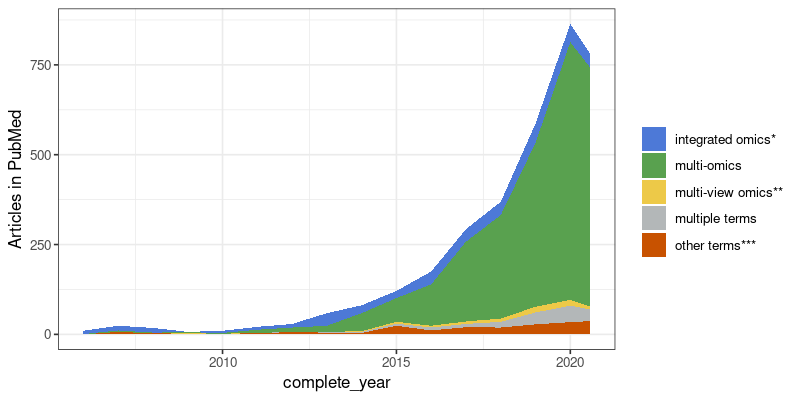

In [44]:
%%R -w 800 -h 400 -r 110 -i term_groups_summary

term_counts = ggplot(term_groups_summary, aes(x=complete_year, fill=term_group, y=count)) +
    geom_area(stat='identity') +
    scale_fill_manual(values=terms_group_colors, name='') +
    theme(legend.position = 'bottom') +
    theme_bw() +
    ylab('Articles in PubMed')
term_counts

In [45]:
from repository_detection import (
    source_code_platforms, mixed_publication_platforms, data_only_platforms,
    all_platforms as platforms
)

In [46]:
mostly_code_platforms = list(source_code_platforms) + ['bioconductor']
mostly_data_platforms = list(set(mixed_publication_platforms) - {'bioconductor'}) + list(data_only_platforms)

In [47]:
platform_id_to_name = {
    '.git': 'Other git',
    'bioconductor': 'Bioconductor',
    'bitbucket': 'Bitbucket',
    'cran': 'CRAN',
    'dryad': 'Dryad',
    'github': 'GitHub',
    'gitlab': 'GitLab',
    'osf': 'OSF',
    'pypi': 'PyPI',
    'sourceforge': 'SourceForge',
    'zenodo': 'Zenodo'
}

In [48]:
from pandas import Categorical

In [49]:
platforms_counts = code_repositories[[f'mentions_{platform}' for platform in platforms]].sum().to_frame('count').sort_values('count')
platforms_counts['platform_id'] = platforms_counts.index.str[len('mentions_'):]
platforms_counts['platform_type'] = platforms_counts.platform_id.apply(lambda p: 'code' if p in mostly_code_platforms else 'data')
platforms_counts.loc['mentions_zenodo', 'platform_type'] = 'both'
platforms_counts['platform_type'] = Categorical(platforms_counts['platform_type'], ordered=True, categories=['code', 'data', 'both'])
platforms_counts['platform_name'] = platforms_counts.platform_id.map(platform_id_to_name)
platforms_counts['platform_name'] = Categorical(platforms_counts['platform_name'], ordered=True, categories=reversed(platforms_counts['platform_name']))

In [50]:
platforms_counts['nudge_y'] = 0
platforms_counts.loc['mentions_gitlab', 'nudge_y'] = -0.5
platforms_counts.loc['mentions_osf', 'nudge_y'] = 0.5
platforms_counts['label_top'] = 0
for i, platform in enumerate(platforms_counts[platforms_counts['nudge_y'] == 0].index):
    platforms_counts.loc[platform, 'label_top'] = (((i % 2) - 0.5) * 2) * -1
platforms_counts

,count,platform_id,platform_type,platform_name,nudge_y,label_top
mentions_dryad,1,dryad,data,Dryad,0.0,1.0
mentions_gitlab,5,gitlab,code,GitLab,-0.5,0.0
mentions_osf,5,osf,data,OSF,0.5,0.0
mentions_pypi,7,pypi,code,PyPI,0.0,-1.0
mentions_zenodo,14,zenodo,both,Zenodo,0.0,1.0
mentions_bitbucket,17,bitbucket,code,Bitbucket,0.0,-1.0
mentions_sourceforge,46,sourceforge,code,SourceForge,0.0,1.0
mentions_.git,56,.git,code,Other git,0.0,-1.0
mentions_cran,82,cran,code,CRAN,0.0,1.0
mentions_bioconductor,116,bioconductor,code,Bioconductor,0.0,-1.0


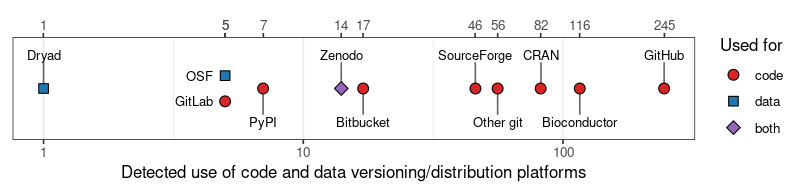

In [51]:
%%R -i platforms_counts -r 110 -w 800 -h 190

code_and_data_platforms = function(text_size=3, point_size=3, scale_name='Used for') {
    (
    ggplot(platforms_counts, aes(y=nudge_y, x=count))
    + geom_text(
        data=platforms_counts[platforms_counts$label_top == 0, ],
        aes(
            label=platform_name,
            x=count - 0.5
        ),
        hjust=1,
        size=text_size
    )
    + ggrepel::geom_text_repel(
        data=platforms_counts[platforms_counts$label_top != 0, ],
        aes(
            label=platform_name,
            nudge_y=label_top * 1.3
        ),
        min.segment.length=0,
        segment.curvature=-1e-20,
        segment.color='grey40',
        point.padding=2.5,
        size=text_size
    )
    + geom_point(
        aes(group=platform_name, fill=platform_type, shape=platform_type),
        color='black',
        size=point_size
    )
    + scale_fill_manual(
        values=c(
            'code'='#d62726',
            'data'='#1f77b4',
            'both'='#9467bd'
        ),
        name=scale_name
    )
    + scale_shape_manual(
        values=c(
            'code'='circle filled',
            'data'='square filled',
            'both'='diamond filled'
        ),
        name=scale_name
    )
    + theme_bw()
    + scale_x_log10(
        sec.axis = dup_axis(breaks=platforms_counts$count, name=element_blank()),
        name='Detected use of code and data versioning/distribution platforms'
    )
    #+ annotation_logticks(sides='b')
    + scale_y_continuous(expand=c(1, 0.5, 1, 0.5)) # bottom mult, bottom add, top mult, top add
    + theme(
        legend.position='right',
        axis.title.y=element_blank(),
        axis.ticks.y=element_blank(),
        axis.text.y=element_blank(),
        panel.grid.major.y=element_blank(),
        panel.grid.minor.y=element_blank(),
    )
    )
}

code_and_data_platforms()

In [52]:
20 / len(data) * 100

0.5788712011577424

In [53]:
from helpers.features import number_of_articles_mentioning_feature, eval_features_frame

In [54]:
domain_features_py = eval_features_frame(domain_features)

In [55]:
from pandas import concat
top_n = 10
features_counts = concat([
    number_of_articles_mentioning_feature(
        domain_features_py,
        Series(['diseases', 'clinical_findings']),
        exclude=['disease']
    ).head(top_n),
    number_of_articles_mentioning_feature(
        domain_features_py,
        Series(['species'])
    ).head(top_n)
]).reset_index()
features_counts.head(2)

,rank,term,count,kind,proportion_of_features,proportion_of_articles
0,0,cancer,786,"diseases,clinical_findings",0.234627,0.227431
1,1,carcinoma,132,"diseases,clinical_findings",0.039403,0.038194


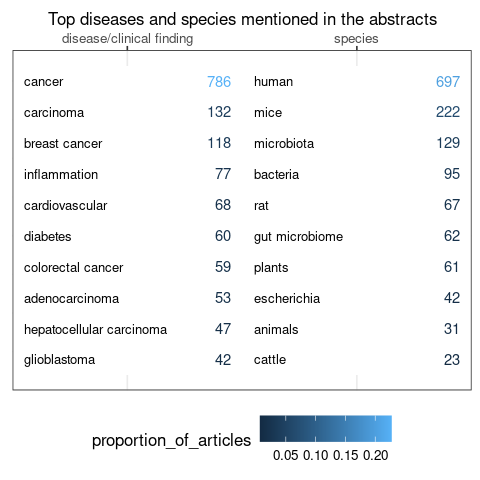

In [56]:
%%R -i features_counts -r 110
plot_features = function(names_padding=0.05, counts_padding=0.05, expand=expansion(mult=0, add=0)) {
    (
    ggplot(features_counts, aes(x=kind, y=rank))
    + geom_tile(fill='white')
    + geom_text(aes(label=strtrim(term, 25)), hjust=0, position=position_nudge(x=-(0.5-names_padding)), size=3)
    + geom_text(
        aes(label=count, color=proportion_of_articles),
        hjust=1, position=position_nudge(x=0.5-counts_padding), size=3.4
    )
    + theme_bw()
    + scale_y_reverse()
    + scale_x_discrete(
        position="top",
        labels=c(
            'diseases,clinical_findings'='disease/clinical finding',
            'species'='species'
        ),
        name='Top diseases and species mentioned in the abstracts',
        expand=expand
    )
    + theme(
        legend.position='bottom',
        axis.title.y=element_blank(),
        axis.ticks.y=element_blank(),
        axis.text.y=element_blank(),
    )
)}
plot_features(names_padding=0.05, counts_padding=0.05)

In [57]:
from omics import omics_by_entity, omics_by_entity_group

In [58]:
omic_entities_columns = Series(list(omics_by_entity.keys()))
omic_entities_group_columns = Series(list(omics_by_entity_group.keys()))
omic_entities = data.rename(columns=prefix_remover('entity_', enforce=False))
omic_entities_groups = data.rename(columns=prefix_remover('entity_group_', enforce=False))
%R -i omic_entities
%R -i omic_entities_groups

[1] "Dropping empty groups: clades (meta_* & pan_*), protein modifications, exogenous factors, clinical data"


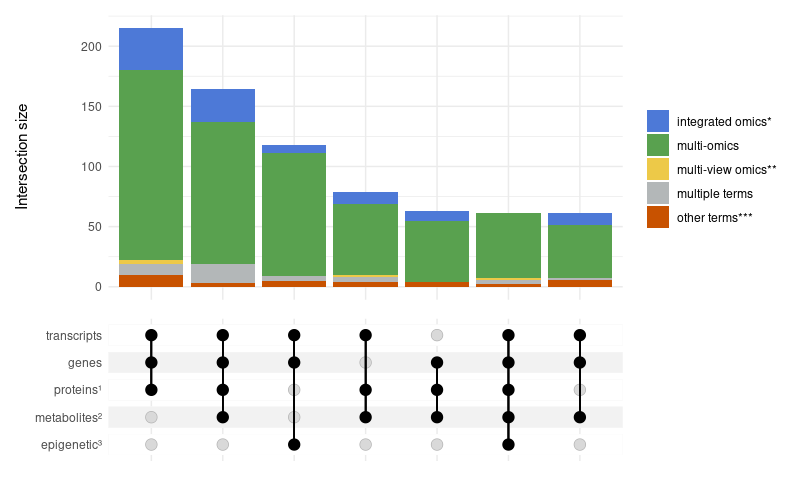

In [59]:
%%R -w 800 -r 100 -i omic_entities_columns

omics_upset = function(...) {
    upset(
        omic_entities,
        omic_entities_columns,
        min_size=50,
        width_ratio=0.2,
        min_degree=2,
        base_annotations=list(
            'Intersection size'=intersection_size(
                counts=FALSE,
                aes=aes(fill=term_group)
            )
        ),
        themes=upset_modify_themes(
            list(
                'overall_sizes'=theme(axis.text.x=element_text(angle=90))
            )
        ),
        labeller=function(x) {
            c(
                'endogenous molecules'='metabolites²',
                'genes'='genes',
                'transcripts'='transcripts',
                'proteins & peptides'='proteins¹',
                'epigenetic modifications'='epigenetic³'
            )[x]
        },
        set_sizes=FALSE,
        ...
    ) + theme(axis.title.x=element_blank()) & scale_fill_manual(values=terms_group_colors, name='')
}
omics_upset()

In [60]:
%%R -r 110 -w 800 -h 800

upset_plot = wrap_elements(
    omics_upset(dot_size=1.75)
    & theme(
        legend.position='none',
        plot.margin=unit(c(0, 0, -0.3, 0), "cm"),
        panel.background=element_rect(fill='transparent', colour=NA),
        plot.background=element_rect(fill='transparent', colour=NA)
    )
    + theme(panel.border=element_rect(color='grey20', fill=NA))
)

TITLE_SIZE = 10
common_theme = theme(
    axis.title.x=element_blank(),
    plot.title=element_text(size=TITLE_SIZE)
)

[1] "Dropping empty groups: clades (meta_* & pan_*), protein modifications, exogenous factors, clinical data"


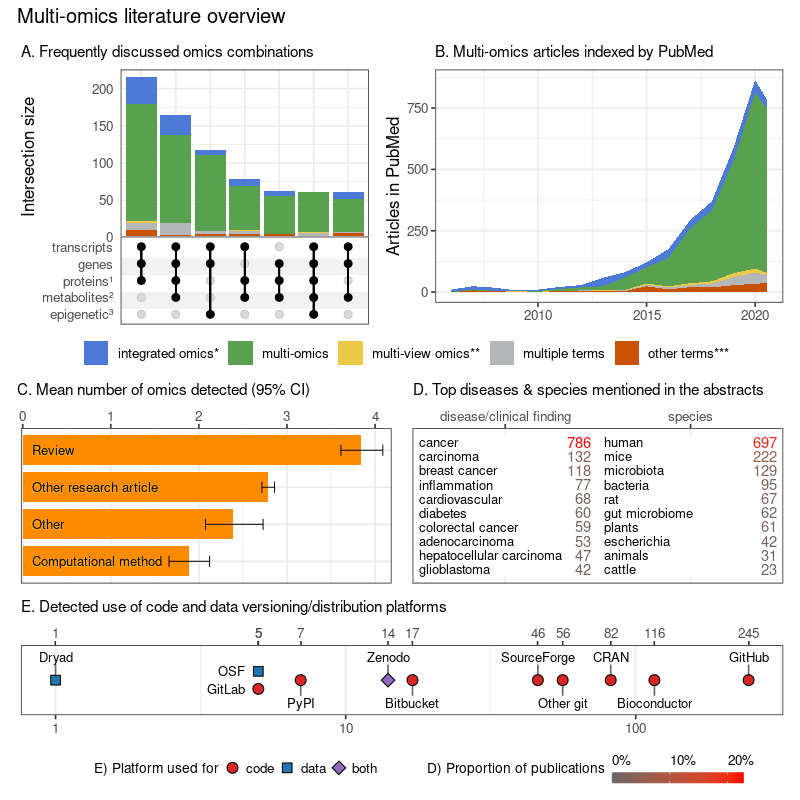

In [61]:
%%R -r 110 -w 800 -h 800
figure = (
    (
        (
            (
                (
                    upset_plot
                    + labs(
                        title='A. Frequently discussed omics combinations'
                    )
                    + common_theme
                )
                |
                (
                    term_counts
                    + common_theme
                    + labs(
                        title='B. Multi-omics articles indexed by PubMed'
                    )
                )
            )
            & theme(legend.position='bottom')
            & plot_layout(guides='collect')
        )
        /
        (
            (
                plot_counts_summary(width=0.8)
                + scale_y_continuous(
                    expand=c(0, 0.02, 0, 0.1),
                    position='right',
                )
                + shadowtext::geom_shadowtext(
                    aes(label=type, y=0.1), hjust=0, size=3,
                    bg.r=0.05, color='black', bg.color='orange'
                )
                + theme(
                    legend.position='right',
                    axis.title.y=element_blank(),
                    axis.ticks.y=element_blank(),
                    axis.text.y=element_blank(),
                    axis.title.x=element_blank(),
                    plot.title.position='plot'
                )
                + common_theme
                + labs(title='C. Mean number of omics detected (95% CI)')
            )
            |
            (
                plot_features(names_padding=0.035, counts_padding=0.035, expand=expansion(add=0.0))
                + guides(
                    color=guide_colorbar(
                        barheight=0.5,
                        label.position='top',
                        title.vjust=0.5,
                        title.theme=element_text(size=9),
                        order=0,
                        #label.vjust=-5,
                        label.hjust=0
                    )
                )
                + common_theme
                + scale_color_gradient(
                    low='grey40',
                    high='red',
                    name='D) Proportion of publications',
                    breaks=c(0.0, 0.1, 0.2),
                    limits=function(automatic_limits) {
                        automatic_limits[[1]] = 0
                        automatic_limits
                    },
                    labels=scales::percent
                )
                + labs(
                    title='D. Top diseases & species mentioned in the abstracts'
                )
            ) & theme(legend.position='bottom')
        )
        /
        (
            code_and_data_platforms(scale_name='E) Platform used for')
            + common_theme
            + labs(
                title='E. Detected use of code and data versioning/distribution platforms'
            )
            + guides(
                fill=guide_legend(
                    keywidth=0.1,
                    title.theme=element_text(size=9),
                )
            )
        ) & theme(
            legend.position='bottom',
            legend.box='horizontal',
            legend.direction='horizontal',
            legend.margin=unit(-15, 'cm'),
        )
    )
    + plot_layout(
        heights=c(3, 2, 0.9),
        guides='collect'
    ) + plot_annotation(title='Multi-omics literature overview')
)
figure

In [62]:
%R ggsave(filename='figures/overview.pdf', plot=figure, scale=1.1)
%R ggsave(filename='figures/overview.png', plot=figure, scale=1.1, device='png', dpi=105)

R[write to console]: Saving 7.33 x 7.33 in image

R[write to console]: Saving 7.33 x 7.33 in image



Compress the PNG if trimage is available:

In [63]:
from shutil import which
from contextlib import redirect_stdout
from io import StringIO

if which('trimage'):
    f = StringIO()
    with redirect_stdout(f):
        !trimage -f figures/overview.png

### Details for captions

Proportion full-text articles among all articles:

In [64]:
(data.has_full_text==True).mean()

0.4399421128798842

Proportion full-text articles among PMC articles (this is because non-PMC are NA, and are not accounted for when calculating the mean below!):

In [65]:
data.has_full_text.mean()

0.779087647360328

### Alternative UpSet plots

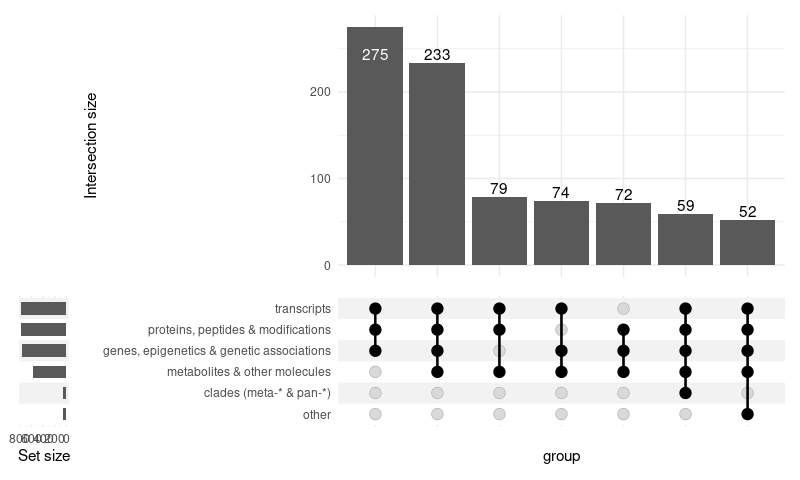

In [66]:
%%R -w 800 -r 100 -i omic_entities_group_columns

upset(omic_entities_groups, omic_entities_group_columns, min_size=50, width_ratio=0.1, min_degree=2)

[1] "Dropping empty groups: clades (meta_* & pan_*), protein modifications, exogenous factors, clinical data"


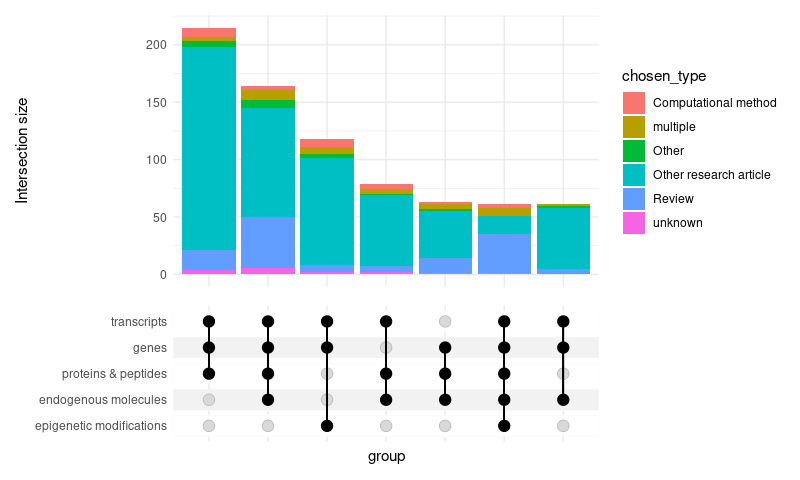

In [67]:
%%R -w 800 -r 100 -i omic_entities_columns

upset(
    omic_entities,
    omic_entities_columns,
    min_size=50,
    width_ratio=0.2,
    min_degree=2,
    base_annotations=list(
        'Intersection size'=intersection_size(
            counts=FALSE,
            aes=aes(fill=chosen_type)
        )
    ),
    themes=upset_modify_themes(
        list(
            'overall_sizes'=theme(axis.text.x=element_text(angle=90))
        )
    ),
    set_sizes=FALSE
)